본 파일은 엔진의 개선을 위한 여러 실험을 효율적으로 진행하기 위해 만들어졌다. 
이 파일로 주로 실험을 진행한다

데이터와 파라미터의 값을 조정하면서 File>make a copy기능을 이용해 파일이름을 'Experiment_xxx(1~8기능)_기타정보' 로 생성하면 된다

현재 물류노드간 전체 흐름도

<img src="PalletSystem.png">

현재 엔진의 기능 중 <br>
## -> 1. 요일묶음(월~일 grouping), 2. holiday 설정<br>
## -> 3. seasonality mode, 4. trend change <br>
## -> 5. outlier 제거, 6. prior<br>
## -> 7. postprocess, 8. prophet 성능저하시 다른 모델로 변경 <br>
의 순서로 기능들을 한 번씩 사용해보는데 의의를 두고, <br>
향후 실험파일들은 데이터와 나머지 기능들은 그대로 유지한채 <b>1~8 중 하나의 기능만</b> 변화시켜면서 결과를 비교해본다.<br>

In [1]:
import os, sys

path_name = os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from Engine.Data.IO import IO
from Engine.Pipeline.pipeline import NextoptBasePipeline,NextoptWeekdayDMPipeline,NextoptWeekdayDMProphetPipeline
from Engine.Data.IO import IO
from Engine.Data.transformer import Transformer
from Engine.Data.explorer import Explorer

# 1. Input
path_name = os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)
print(path_name)

data_dir = path_name + '/Data/DB'

/Users/moonygo/Documents/NextoptEngine_light


## 0. Data

위 그림중 어떤 물류흐름에 해당하는 데이터인지 설정

<img src="PalletFlowDataType.png">

In [2]:
df_pallets = IO.read_pickle(data_dir + '/KPP일별_발주_유형별전처리.pkl') 
# 2. Transformer
df_pallets.head()
df_pallets.transformer.dt_format = '%Y%m%d' 

In [3]:
df_pallets = IO.read_pickle(data_dir + '/KPP일별_From5_To2_유형별전처리.pkl') 
# 2. Transformer
df_pallets.head()
df_pallets.transformer.dt_format = '%Y%m%d' 

다음 파렛트 유형중에 선택 하여 df_pallets.transformer.get(code=['N11']) code에 넣는다

In [4]:
df_pallets.columns

Index(['AP11', 'AP12', 'AP95', 'BAG', 'C11', 'C95', 'D11', 'EL14', 'EL18',
       'GIT', 'GP12', 'GTW', 'H11', 'IN11', 'L12', 'L14', 'L14J', 'N11',
       'N11R', 'N11S', 'N11Y', 'N12', 'N15', 'NG11R', 'P05', 'P06', 'P10',
       'P11', 'P11R', 'P12', 'P13', 'P14', 'P15', 'P94', 'PA11', 'PA12',
       'PA95', 'PG11R', 'R12', 'R14', 'R14Y', 'S11', 'TOT', 'W08J', 'W11',
       'W12', 'W13', 'W14', 'WP11', 'WP12'],
      dtype='object')

In [5]:
df = df_pallets.transformer.get(code=['P14'], weekday=[0,1,2,3,4,5,6],start='2010-01-01', end='2017-12-31').fillna(0.0)

데이터를 가져올 때 start= , end= parameter를 통해 어떤 기간의 데이터를 가져올건지 결정가능(참고: trend chang와 관련있음)

## 1. 요일묶음

### 해당 파렛트의 요일별 추이 확인 후 묶음 결정

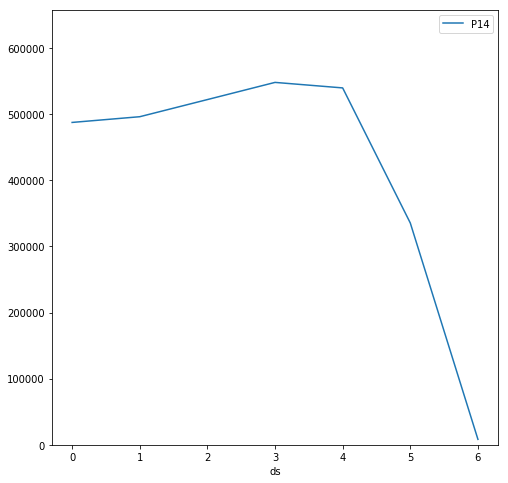

In [6]:
df.explorer.plot_by_weekday()

In [7]:
# weekday 월요일 - 0 ...  일요일 - 6
df = df_pallets.transformer.get(code=['N11'], weekday=[0,1,2,3,4,5,6])
df = df.fillna(0)
df = df.reset_index()
df.columns = ['ds','y']

In [8]:
pipeline = NextoptWeekdayDMProphetPipeline()
pipeline.raw_data = df
pipeline.horizon = 30 # 예측할 기간(defualt: 30)
pipeline.unit = 'd'

SET INDEX AS DS(DateTimeIndex)


In [9]:
#pipeline.division_condition = ['01234','5','6'] # mon - thur, sat, sun
#pipeline.division_condition = ['0','1','2','3','4','5','6'] # mon - thur, sat, sun

#pipeline.division_condition=['01234','5','6']

pipeline.division_condition=['0123456']
pipeline.division_condition

DIVIDE TRAIN BY WEEKDAY
DIVIDE EACH FOLD BY WEEKDAY


{0: [0, 1, 2, 3, 4, 5, 6]}

## 2. holiday: 설날과 추석 & 일반 공휴일

In [10]:
df_holiday_main = IO.read_pickle('../../Data/기타/holiday/1. 설날과추석.pkl')
df_holiday_sub = IO.read_pickle('../../Data/기타/holiday/2. 일반공휴일.pkl')

In [11]:
df_holiday_main['lower_window'] = 0
df_holiday_main['upper_window'] = 0
df_holiday_main['holiday'] = '중요휴일'

df_holiday_sub['lower_window'] = 0
df_holiday_sub['upper_window'] = 0
df_holiday_sub['holiday'] = '보통휴일'

df_holidays = pd.concat([df_holiday_main, df_holiday_sub])

기타 holiday관련 조정가능한 목록

### 다음은 여기서 변경할 수 없고, fit을 다 한 후 postprocess에서 해야

In [12]:
#pipeline.postprocess(holiday_correction_dict={0: df_holiday_main,
#                                          0.5: df_holiday_sub,
#                                         })
#pipeline.evaluate()

## 3. Seasonality Mode 

additive를 할건지 multiplicative를 할건지 결정: 평균값이 증가함에 따라 분산도 함께 커지면, seasonality는 add/multiple 중 후자가 맞다 (holtswinter와도 관련)

## 4. Trend Change

Trend를 보고, 활용할 데이터의 가중치나 parameter를 다르게 설정하면 됨

## fold의 조건을 설정가능

In [13]:
pipeline.cross_validation_split(fold = 1)

#pipeline.division_condition = ['0','1','2','3','4','5','6'] # mon - thur, sat, sun

#pipeline.division_condition=['01234','5','6']

#pipeline.division_condition=['012345','6']
#pipeline.division_condition
pipeline.division_condition = ['0','1','2','3','4','5','6'] 
pipeline.division_condition

CROSS VALIDATION SPLIT IS DONE.
DIVIDE TRAIN BY WEEKDAY
DIVIDE EACH FOLD BY WEEKDAY


{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6]}

In [14]:
pipeline.model = Prophet(
        daily_seasonality= False,
        weekly_seasonality= True,
        yearly_seasonality= True,
        holidays = df_holidays
)

In [15]:
pipeline.fit_and_predict()

FOLD  1  DIVISION  1  RESET TRAIN, TEST INDEX FOR PROPHET MODEL


/anaconda3/envs/nextopt/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


FOLD  1  DIVISION  2  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  3  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  4  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  5  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  6  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  7  RESET TRAIN, TEST INDEX FOR PROPHET MODEL
FOLD  1  DIVISION  1  FIT AND FORECAST DONE
FOLD  1  DIVISION  2  FIT AND FORECAST DONE
FOLD  1  DIVISION  3  FIT AND FORECAST DONE
FOLD  1  DIVISION  4  FIT AND FORECAST DONE
FOLD  1  DIVISION  5  FIT AND FORECAST DONE
FOLD  1  DIVISION  6  FIT AND FORECAST DONE
FOLD  1  DIVISION  7  FIT AND FORECAST DONE


In [16]:
pipeline.merge_forecast()

MERGE DIVIDED FORECAST INTO FORECAST_TRAIN & FORECAST_TEST


In [21]:
pipeline.postprocess(holiday_correction_dict={0: df_holiday_main,
                                          0: df_holiday_sub
                                         })
pipeline.evaluate()

POSTPROCESS YHAT = 0 IF YHAT < 0
POSTPROCESS Holiday
POSTPROCESS YHAT = 0 IF YHAT < 0
POSTPROCESS Holiday


In [22]:
pipeline.print_summary()

   Fold       From         To      Real     Predict     Error  Error(%)  \
1     1 2017-12-02 2017-12-31  994962.0  1039646.05 -44684.05     -4.49   

   Total Error  Total Error(%)     RMSE         MAPE  sMAPE  
1    114693.85           11.53  6108.36  21308361.62  11.27  


Fold  1 	 2017-12-02 00:00:00  -  2017-12-31 00:00:00


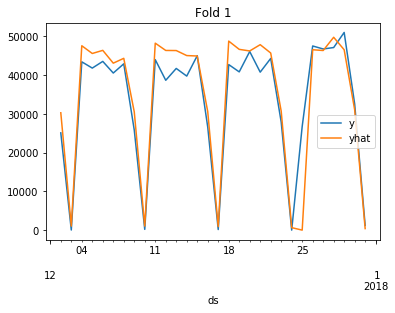

In [23]:
pipeline.plot_forecast()